## Homework3
### Zhengqian Xu

## 1. Autoencoder 

## Problem 1: Autoencoder
A convolutional autoencoder is a particular  avor of autoencoder where we use convolutional layers instead of Dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers. 

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we've used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html. DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME UP WITH YOUR OWN VARIATION.

After training your network, visualize some examples of input images and their decoded reconstruction.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, array_to_img
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

import nltk
import string
import tensorflow as tf
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
#Download the data 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

In [4]:
## adapt this if using `channels_first` image data format
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
#Choose epochs=10 
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 117s 2ms/step - loss: 0.3509 - val_loss: 0.3314
Epoch 2/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.3227 - val_loss: 0.3208
Epoch 3/10
60000/60000 [==============================] - 120s 2ms/step - loss: 0.3125 - val_loss: 0.3174
Epoch 4/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.3077 - val_loss: 0.3071
Epoch 5/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.3044 - val_loss: 0.3097
Epoch 6/10
60000/60000 [==============================] - 131s 2ms/step - loss: 0.3020 - val_loss: 0.3028
Epoch 7/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.3001 - val_loss: 0.3003
Epoch 8/10
60000/60000 [==============================] - 123s 2ms/step - loss: 0.2984 - val_loss: 0.2966
Epoch 9/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.2971 - val_loss: 0.2

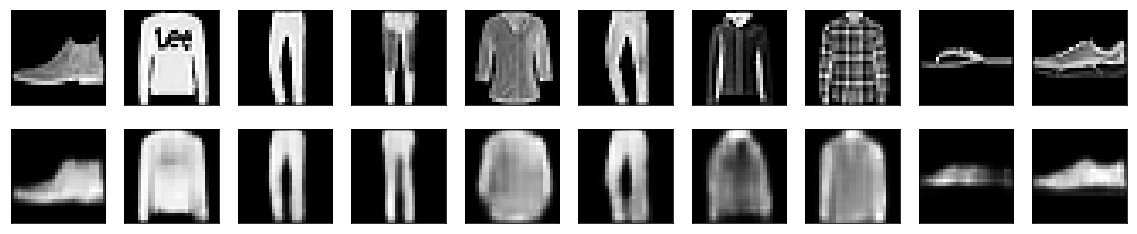

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Problem 2: Image Preprocessing
We'll continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.

### 2.1 Deep CNN
Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.

In [8]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [9]:
model = Sequential()
##Set up the kernel size, padding 

model.add(Conv2D(filters =64 ,kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='same',
                 input_shape=(28,28,1)))

#Set the 2 by 2 Maxpooling layer 
#Set 0.25 Dropout rate
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64,kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
#Sete fully connected layer with 64 Dense nodes
#Set 0.5 Dropout rate
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________

In [10]:
#Model Complice
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Fit the model 
#Set the epoch=5
#Set the validation rate as 30%
model.fit(x_train, Y_train,
          epochs=5,
          batch_size=128,
          validation_split = 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 222s 5ms/step - loss: 0.3832 - acc: 0.8636 - val_loss: 0.2867 - val_acc: 0.8977
Epoch 2/5
42000/42000 [==============================] - 194s 5ms/step - loss: 0.3517 - acc: 0.8746 - val_loss: 0.2872 - val_acc: 0.8943
Epoch 3/5
42000/42000 [==============================] - 184s 4ms/step - loss: 0.3295 - acc: 0.8838 - val_loss: 0.2527 - val_acc: 0.9086
Epoch 4/5
42000/42000 [==============================] - 210s 5ms/step - loss: 0.3138 - acc: 0.8874 - val_loss: 0.2449 - val_acc: 0.9112
Epoch 5/5
10000/10000 [==============================] - 13s 1ms/step


In [13]:
#Evaluate Model 
test_score = model.evaluate(x_test, Y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.270441812813282
Test accuracy: 0.9007


I use two convolution layers and each layer accompanied with 64 3 by 3 filters, striding 1 by 1. Each convolution layer is followed by a max pooling layer with size 2 by 2. I apply the drop out at the last max pooling layer.Then I add two dense layers with 64 and 10 neurons respectively, accompanied with a drop out on both layear. I also apply relu activation on all layer except for the last layer, where softmax is used.

Based on the results, the accuracy of both training and validation set is around 90% and the accuracy of test is also about 90%.

### 2.2 Transfer Learning
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model's performance on training set and test set.

In [12]:
from keras.applications import ResNet50
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))
transfer_model = Sequential()
transfer_model.add(conv_base)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation="relu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(10, activation="softmax"))   
conv_base.trainable = False
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
#load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

x_train = np.dstack([x_train] * 3)
x_test = np.dstack([x_test] * 3)

x_train = x_train.reshape(-1, 28, 28, 3)
x_test = x_test.reshape (-1, 28, 28, 3)
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in x_train])/255.
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in x_test])/255.

x_train.shape, x_test.shape

((60000, 50, 50, 3), (10000, 50, 50, 3))

In [14]:
conv_base.trainable = False
transfer_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["acc"])

In [62]:
transfer_model.fit(x_train, Y_train,
          epochs=5,
          batch_size=128,
          validation_split = 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 2233s 53ms/step - loss: 0.8289 - acc: 0.7052 - val_loss: 0.5920 - val_acc: 0.7904
Epoch 2/5
42000/42000 [==============================] - 2462s 59ms/step - loss: 0.6040 - acc: 0.7850 - val_loss: 0.5357 - val_acc: 0.8090
Epoch 3/5
42000/42000 [==============================] - 2439s 58ms/step - loss: 0.5507 - acc: 0.8026 - val_loss: 0.5077 - val_acc: 0.8171
Epoch 4/5
42000/42000 [==============================] - 1839s 44ms/step - loss: 0.5254 - acc: 0.8107 - val_loss: 0.4927 - val_acc: 0.8224
Epoch 5/5
42000/42000 [==============================] - 1892s 45ms/step - loss: 0.5048 - acc: 0.8176 - val_loss: 0.4758 - val_acc: 0.8268


In [63]:
#Evaluate model 
test_score = transfer_model.evaluate(x_test, Y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

10000/10000 [==============================] - 337s 34ms/step
Test loss: 0.48518225479125976
Test accuracy: 0.8228


Based on the result, we can see that the accuracy of traning data is about 81% and validation data is about 82%. Also, the accuracy of test set is about 82.3%. 

## Problem 3: Text Classification

### 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [15]:
text_data = pd.read_csv('tweets_with_labels.csv',sep='\t')

In [16]:
text_data.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [17]:
## process the tweets
def process_tweets(tweets):
    tweets_clean=[]

    for tweet in tweets:

        # Process text
        tokens = nltk.casual_tokenize(tweet)

        # Remove URL
        tokens =[term for term in tokens if not term.startswith('{') ]

        # Remove profiles
        tokens1 = [term for term in tokens if not term.startswith('@')]

        # Remove punctuation
        punctuation = list(string.punctuation)
        tokens2 = [term for term in tokens1 if term not in punctuation]

        # Remove hashtags
        tokens3 = [term for term in tokens2 if not term.startswith('#')]
        
        if tokens3 != []:
            
            sentence3 = ' '.join(tokens3)
        else:
            sentence3 = 'no words left'
        
        tweets_clean.append(sentence3)
    
    return tweets_clean

In [18]:
text_data['tweet_clean'] = process_tweets(text_data['tweet'])

In [19]:
## get the clean tweets
text_clean = text_data[text_data['tweet_clean']!= 'no words left']

In [20]:
text_clean.head(5)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweet_clean
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,Jazz for a Rainy Afternoon link
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,RT I love rainy days
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Good Morning Chicago Time to kick the Windy Ci...
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,Preach lol :) RT this type of weather all the ...
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine


In [21]:
text = text_clean['tweet_clean']
label =  text_clean.iloc[:,2:-1].values

In [22]:
## split data
text_train,text_test,label_train,label_test = train_test_split(text,label,test_size=0.2,random_state=12)

MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_train)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

text_train_2 = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_test_2 = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

## split train data into training and validation
train_text = text_train_2[:50000]

val_text = text_train_2[50000:]

train_label = label_train[:50000]

val_label = label_train[50000:]

In [23]:
## make model of LSTM
model_RNN = Sequential()
model_RNN.add(Embedding(MAX_NUM_WORDS, 64))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model_RNN.add(LSTM(32))
model_RNN.add(Dense(15, activation ='softmax'))
model_RNN.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',

             metrics=['acc'])
rnn_history = model_RNN.fit(train_text,train_label,epochs = 10,validation_data = (val_text, val_label), batch_size = 64,verbose=1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/10
50000/50000 [==============================] - 35s 701us/step - loss: 1.7858 - acc: 0.6438 - val_loss: 1.3865 - val_acc: 0.7631
Epoch 2/10
50000/50000 [==============================] - 35s 709us/step - loss: 1.3030 - acc: 0.7920 - val_loss: 1.3002 - val_acc: 0.7866
Epoch 3/10
50000/50000 [==============================] - 35s 698us/step - loss: 1.2477 - acc: 0.8006 - val_loss: 1.2487 - val_acc: 0.7943
Epoch 4/10
50000/50000 [==============================] - 36s 721us/step - loss: 1.2234 - acc: 0.8036 - val_loss: 1.2531 - val_acc: 0.7965
Epoch 5/10
50000/50000 [==============================] - 37s 743us/step - loss: 1.2081 - acc: 0.8061 - val_loss: 1.2338 - val_acc: 0.8000
Epoch 6/10
50000/50000 [==============================] - 38s 765us/step - loss: 1.1970 - acc: 0.8085 - val_loss: 1.2113 - val_acc: 0.8030
Epoch 7/10
50000/50000 [==============================] - 40s 809us/step - loss: 1.1888 - acc: 0.8091 - val_loss: 1.

In [24]:
RNN_loss, RNN_acc = model_RNN.evaluate(text_test_2, label_test)
# Test Error
print('The loss of test data is:', RNN_loss)
print('The accuray of test data is: %.2f%%' % (RNN_acc*100))

15580/15580 [==============================] - 4s 251us/step
The loss of test data is: 1.209398360032019
The accuray of test data is: 80.17%


### 3.2 CNN
Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings).

In [25]:
model_CNN = Sequential()
model_CNN.add(Embedding(MAX_NUM_WORDS,64))
model_CNN.add(Conv1D(64, kernel_size = 3,padding='valid',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.3))
model_CNN.add(Dense(64,activation='relu'))
model_CNN.add(Dense(15,activation='softmax'))
model_CNN.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['acc'])
cnn_history = model_CNN.fit(train_text,train_label,epochs = 10,validation_data = (val_text, val_label), batch_size = 64,verbose=1)

Train on 50000 samples, validate on 12320 samples
Epoch 1/10
50000/50000 [==============================] - 1367s 27ms/step - loss: 1.6063 - acc: 0.7088 - val_loss: 1.2647 - val_acc: 0.7963
Epoch 2/10
50000/50000 [==============================] - 1347s 27ms/step - loss: 1.3069 - acc: 0.7945 - val_loss: 1.2373 - val_acc: 0.7970
Epoch 3/10
50000/50000 [==============================] - 1291s 26ms/step - loss: 1.2682 - acc: 0.7974 - val_loss: 1.2162 - val_acc: 0.8011
Epoch 4/10
50000/50000 [==============================] - 1289s 26ms/step - loss: 1.2434 - acc: 0.7991 - val_loss: 1.2095 - val_acc: 0.7993
Epoch 5/10
50000/50000 [==============================] - 1243s 25ms/step - loss: 1.2258 - acc: 0.8018 - val_loss: 1.2026 - val_acc: 0.8049
Epoch 6/10
50000/50000 [==============================] - 1314s 26ms/step - loss: 1.2142 - acc: 0.8014 - val_loss: 1.2005 - val_acc: 0.8017
Epoch 7/10
50000/50000 [==============================] - 1281s 26ms/step - loss: 1.2020 - acc: 0.8056 - val_l

In [26]:
CNN_loss, CNN_acc = model_CNN.evaluate(text_test_2, label_test)
# Test Error
print('The loss of test data is:', CNN_loss)
print('The accuray of test data is: %.2f%%' % (CNN_acc*100))

15580/15580 [==============================] - 2s 132us/step
The loss of test data is: 1.2012275268850952
The accuray of test data is: 80.32%


### 3.3
Be sure to directly compare your two methods with an ROC curve or similar validation method. Don't forget to create a train-test split.

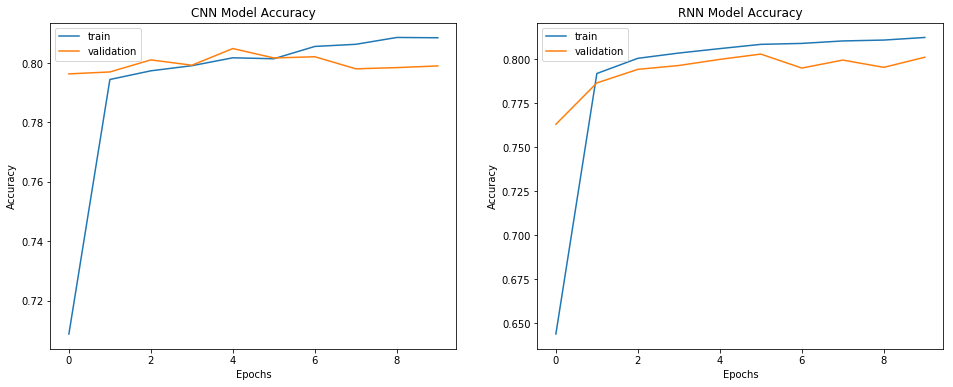

In [27]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

We can see that the accuracy of both methods are quite similar.
The test accuracy for CNN is 80.17% while for RNN is 80.32%.